# Intro


Cilem tohoto notebooku je projit a pochopit clanek a evaluaci strategii:

http://blueowlpress.com/system-development/all-things-being-equal-risk-and-reward/

Vysledkem by melo byt porovnani na jiz zvolene tradovaci strategii.

# Save_f


$f \in [{0, 1}]$  je procento z portfolia, ktere jsme ochotni investovat, abychom dosahli urcite hladiny risku.

Napr. chceme, aby pravdepodobnost, ze nastane drawdown >= 10% byla mensi nez 5%.

# Distribuce tradu

Nejzajimavejsi cast tohot prispevku je, ze on vubec nepredpoklada, ze by vyvoj ceny v budoucim horizontu byla stejna, ale doufa, ze distribuce tradu bude stejna, jako v ucici mnozine.


# Postup vypoctu - monte carlo

- Vezmeme vsechny trady z validacni moziny (validacni mnozina, by mela byt vetsi nez caso horizont, za ktery chceme risk odhadnout.

- Validacni trady pokladame za sample distribuce tradu.

- $T$ = kolik tradu se udela v prumeru za casovy horizont, ktery chceme odhadnout.

- $N$ krat (alespon 1000x) provedeme nahodny vyber $T$ tradu z validacni mnoziny a spocteme por ne:

    - maximalni drawdown
    - finalni profit

- Z $N$ hodnot spocitame distribuci max drawdownu

- Koukneme na inverzni CDF distribuce pro $f$ = 1 - cili kdybychom obchodovali s celym portfoliem

- Najdeme takove $f$, ktere by splnovalo nase parametry risku

- Evidnetne cim je $f$ blize 1 tim lepe

In [1]:
%run ../../../utils/commonImports.py
%run ../../../utils/tradingImports.py
%matplotlib inline

import sys
sys.path.append(os.path.abspath("../../../modeling/07-base-strategy-03"))

from base import supres, BaseStrategy
from exputils import *

# Strategy stats

Na datech za 2 roky

In [18]:
strategy_train = load_model('vtc-strategy-train.pkl')
report_train = strategy_train.stats('btc').report()
strategy_test = load_model('vtc-strategy-test.pkl')
report_test = strategy_test.stats('btc').report()

report = report_train.join(report_test, lsuffix='_train', rsuffix='_test')
report

,btc_train,btc_test
startAmount,100.0000,100.0000
numberOfTrades,731.0000,293.0000
totalProfit,943.9831,186.2407
avgProfit,1.2914,0.6356
winPercentage,83.4473,79.1809
avgWinTrade,1.9505,1.3043
avgLossTrade,-2.0314,-1.9075
profitFactor,4.8404,2.6006
maxDrawdown,6.7774,8.5457
avgTimeToClose,4.1635,8.7116


In [69]:
from random import sample 
from utils.parallel import run_parallel
from multiprocessing import Manager

manager = Manager()
Global = manager.Namespace()


def sample_transactions(transactions, t):
    buy_indices = sample(range(0, len(transactions), 2), t)
    sampled = []
    for i in buy_indices:
        sampled.append(transactions[i])
        sampled.append(transactions[i+1])
    return sampled


def monte_carlo_f(args):
    strategy_global, t_global = Global.args
    origin_transactions = strategy_global.exchange.transactions
    contract_name = 'btc'
    
    sampled = sample_transactions(origin_transactions, t_global)
    stats = Statistics(contract_name, strategy_global.wallet_start[contract_name])\
        .evaluate(sampled)\
        .report()
    return stats

def monte_carlo(strategy, n, t):
    Global.args = [strategy, t]
    args = [0] * n
    stats_list = run_parallel(monte_carlo_f, args, 20)
    return stats_list

In [65]:
t = int(report_train.loc['numberOfTrades', 'btc'] / 2)
n = 10000
stats_train = monte_carlo(strategy_train, n, t)

In [70]:
t = int(report_test.loc['numberOfTrades', 'btc'] / 1.25)
n = 10000
stats_test = monte_carlo(strategy_test, n, t)

# Calc cdf

In [71]:
def cdf(values, step):
    _min, _max = min(values), max(values)
    bins = range(int(_min), int(_max)+1, step)
    pdf = np.array([len([x for x in values if (x >= i) and (x < i+step)]) for i in bins])
    pdf = pdf / pdf.sum()
    return pdf.cumsum(), bins

In [87]:
def plot_cdf_from_stats(stats_list, what, ax, title):
    values = [x.loc[what, 'btc'] for x in stats_list]
    d_cdf, bins = cdf(values, 1)
    
    sns.lineplot(d_cdf, bins, ax=ax)
    ax.set_xlabel('percentile', fontproperties=axis_font)
    ax.set_ylabel(what, fontproperties=axis_font);
    ax.axvline(x=0.95, c='g');
    ax.set_title(title, fontproperties=title_font)

In [92]:
def compare_stats(stats_train, stats_test, what):
    f, axes = plt.subplots(1, 2, figsize=[15, 6])
    plot_cdf_from_stats(stats_train, what, axes[0], 'Train')
    plot_cdf_from_stats(stats_test, what, axes[1], 'Test')

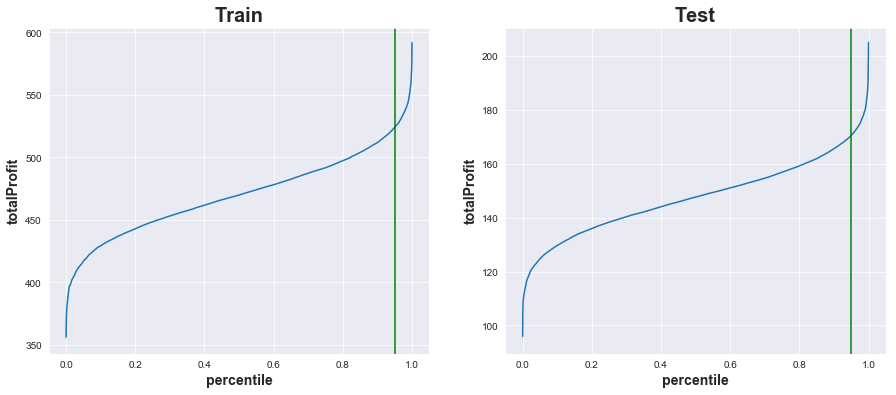

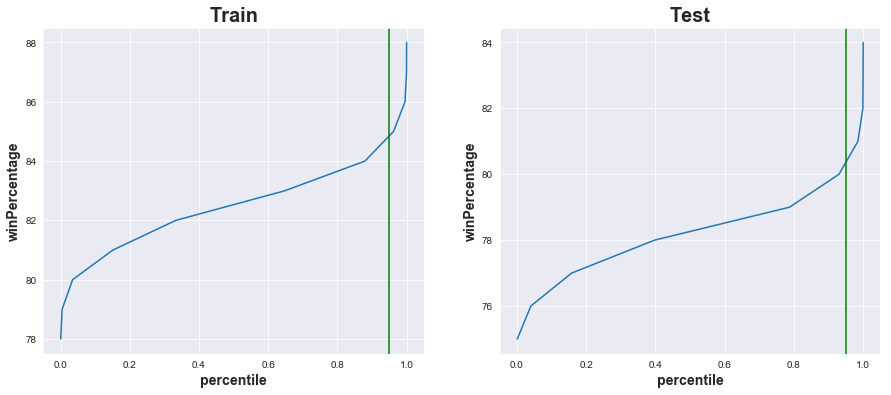

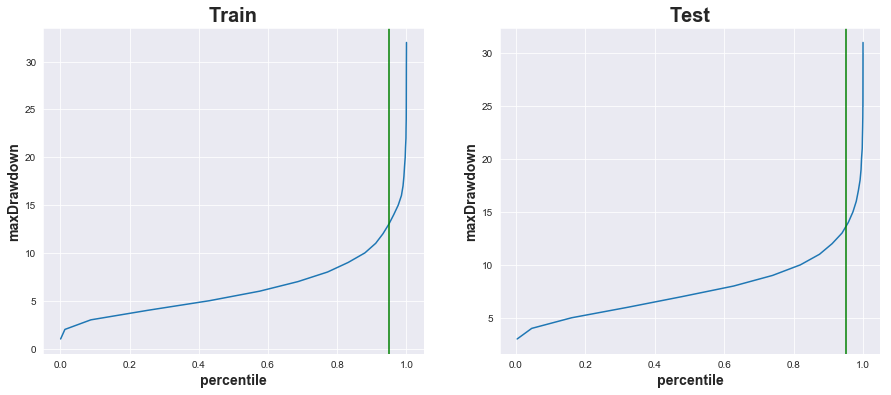

In [93]:
for col in ['totalProfit', 'winPercentage', 'maxDrawdown']:
    compare_stats(stats_train, stats_test, col)

# Trade distribution

In [94]:
def returns_from_transactions(transactions):
    buys = transactions[::2]
    sells = transactions[1::2]
    paired = zip(buys, sells)
    returns = [(sell['price'] / buy['price']) - 1 for buy, sell in paired]
    return returns

In [111]:
def plot_trades_distb(transactions, ax, title):
    _returns = returns_from_transactions(transactions)
    
    sns.distplot(_returns, ax=ax, hist=True, norm_hist=True)
    ax.set_xlabel('return', fontproperties=axis_font)
    ax.set_title(title, fontproperties=title_font)

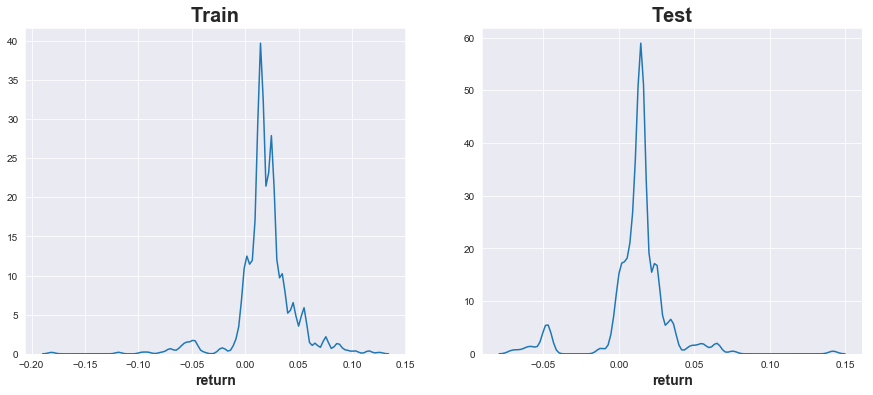

In [110]:
transactions_train = strategy_train.exchange.transactions
transactions_test = strategy_test.exchange.transactions

f, axes = plt.subplots(1, 2, figsize=[15, 6])
plot_trades_distb(transactions_train, axes[0], 'Train')
plot_trades_distb(transactions_test, axes[1], 'Test')